In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [2]:
az.style.use('arviz-white')

## PyMC primer

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0], dtype=int64)

In [4]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


### Summarizing the posterior

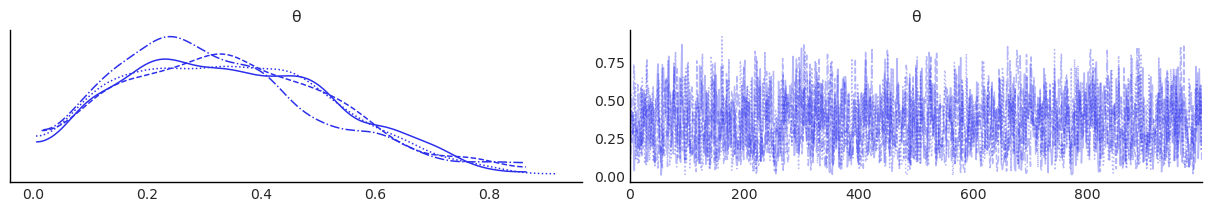

In [5]:
az.plot_trace(idata)
plt.savefig('B11197_02_01.png')

In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.341,0.18,0.039,0.665,0.004,0.003,1729.0,2100.0,1.0


#### Posterior-based decisions

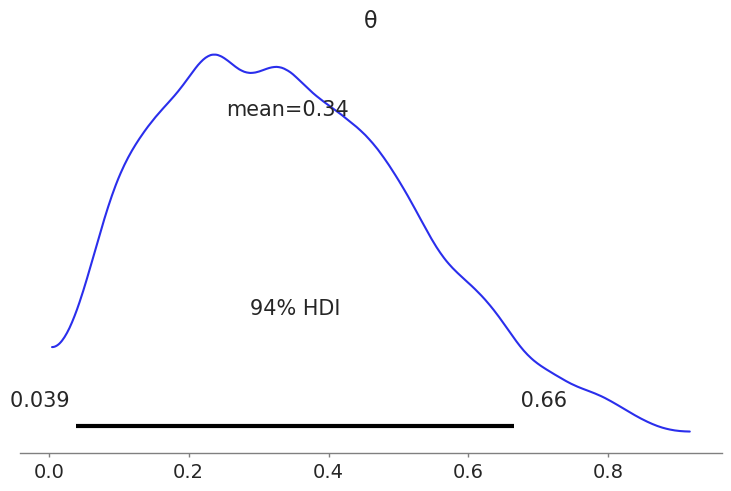

In [7]:
az.plot_posterior(idata)
plt.savefig('B11197_02_02.png')

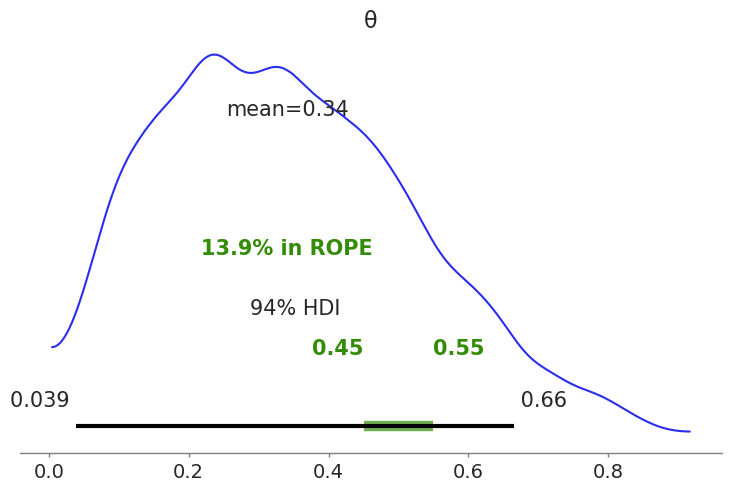

In [8]:
az.plot_posterior(idata, rope=[0.45, .55])
plt.savefig('B11197_02_03.png')

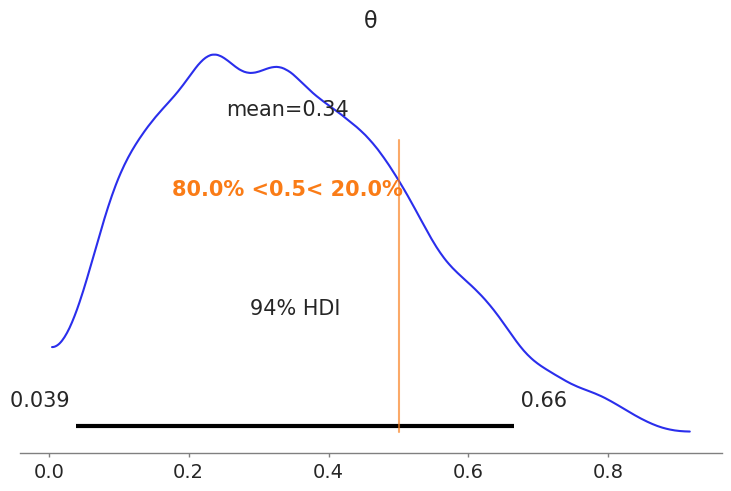

In [9]:
az.plot_posterior(idata, ref_val=0.5)
plt.savefig('B11197_02_04.png')

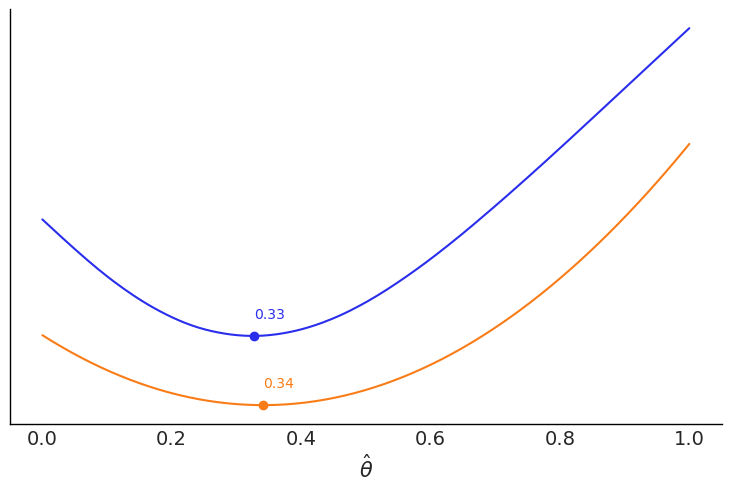

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png')

In [11]:
np.mean(θ_pos).item(), np.median(θ_pos)

(0.3410502090112653, 0.3269839299552647)

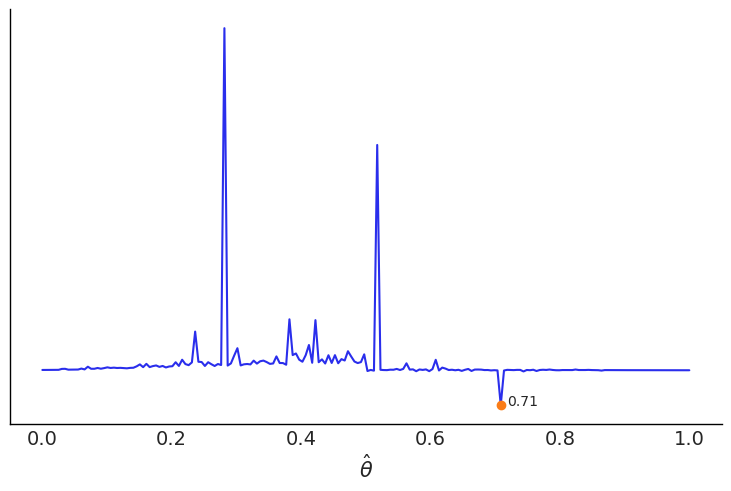

In [12]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png')

## Gaussian inferences

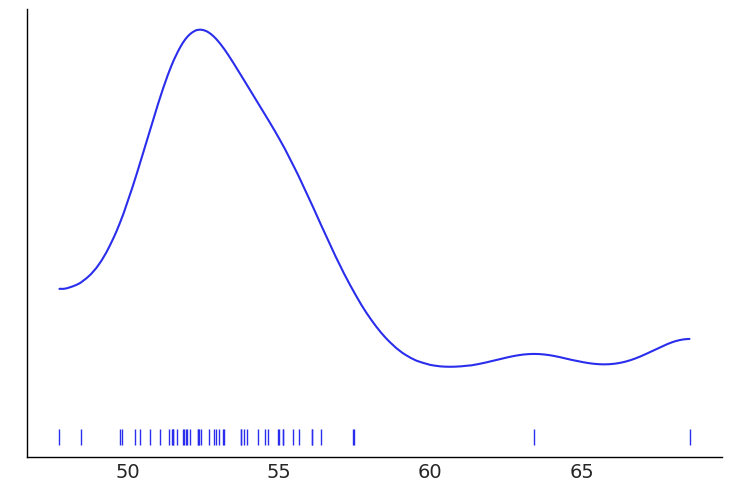

In [14]:
data = np.loadtxt('../../code_3_11/data/chemical_shifts.csv')

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png')

 <img src="B11197_02_08.png" width="500">

In [15]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=10)
    y = pm.Normal('y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


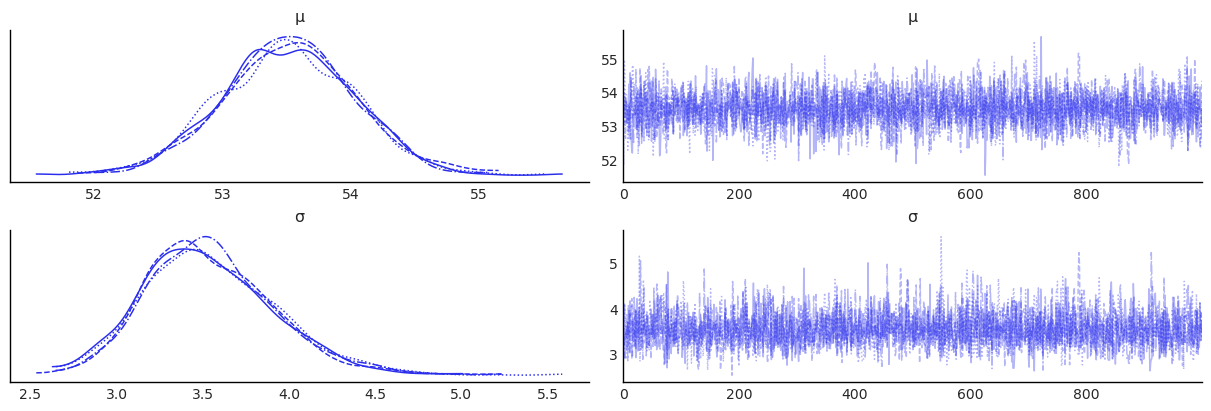

In [16]:
az.plot_trace(idata_g)
plt.savefig('B11197_02_09.png')

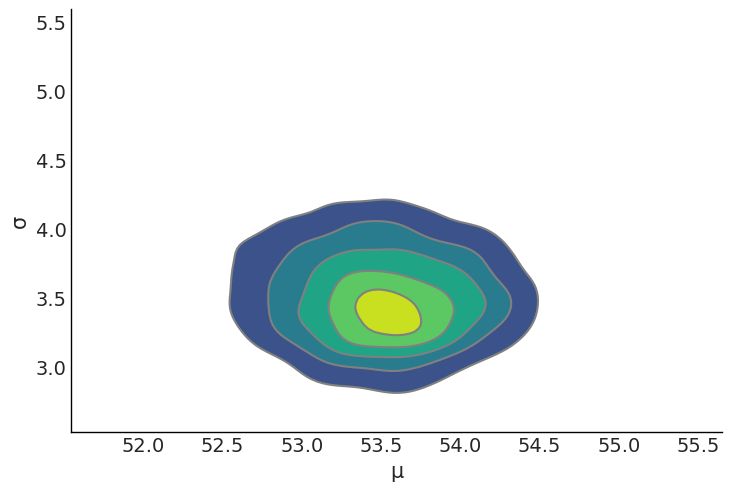

In [17]:
az.plot_pair(idata_g, kind='kde')
plt.savefig('B11197_02_10.png')

In [18]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.510,0.515,52.519,54.426,0.009,0.006,3200.0,2516.0,1.0
σ,3.545,0.377,2.865,4.250,0.007,0.005,3035.0,2334.0,1.0


In [19]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Sampling: [y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

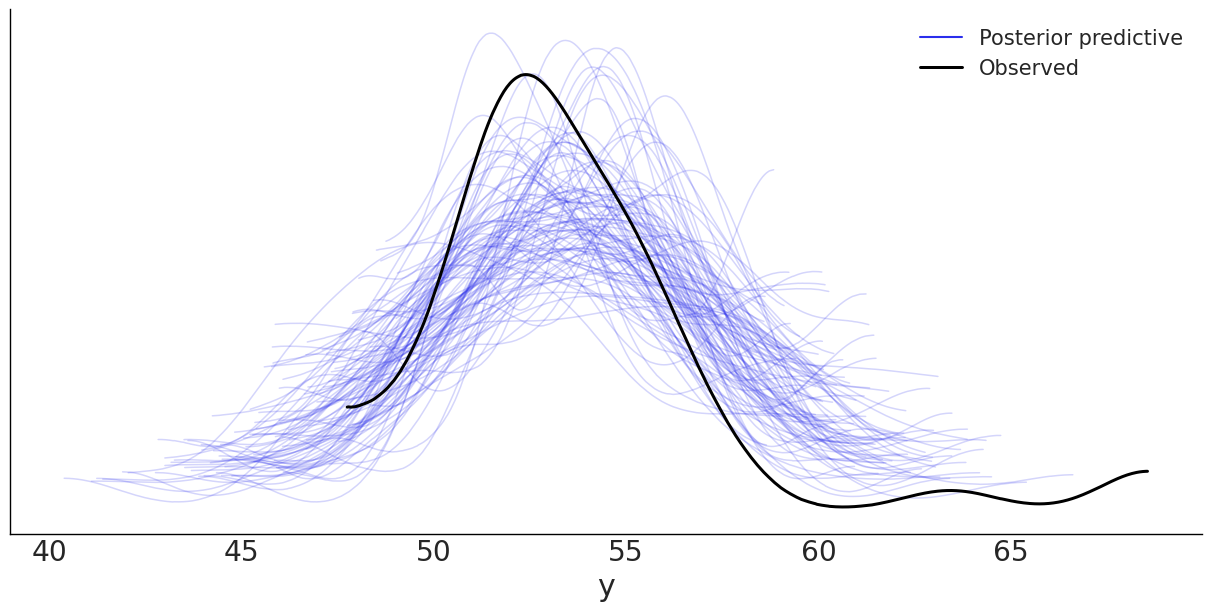

In [20]:
ax = az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 6), mean=False)
plt.savefig('B11197_02_11.png')

### Robust inferences

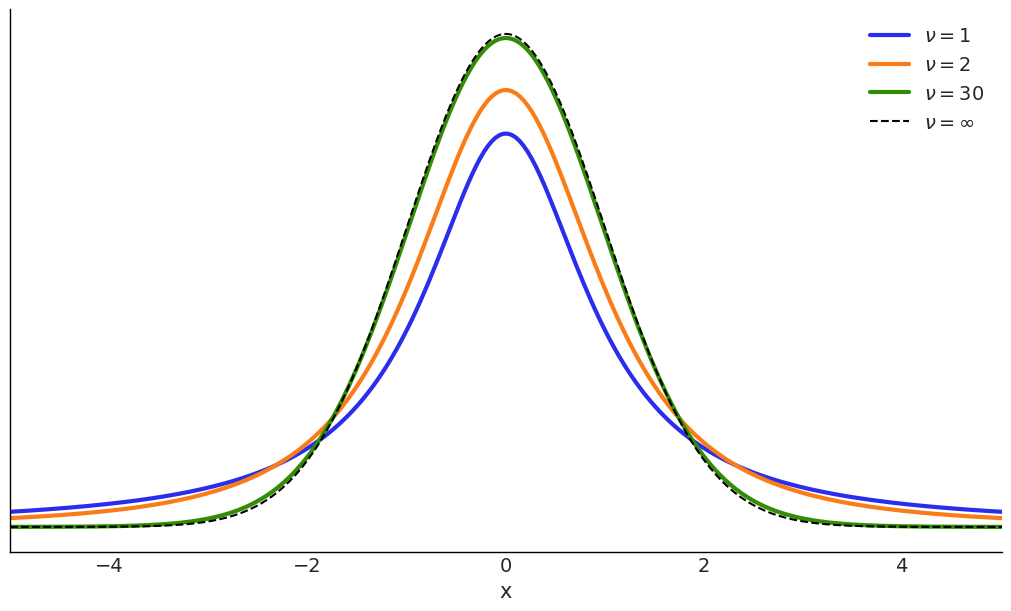

In [21]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png')

 <img src="B11197_02_13.png" width="500">

In [22]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=data)
    idata_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


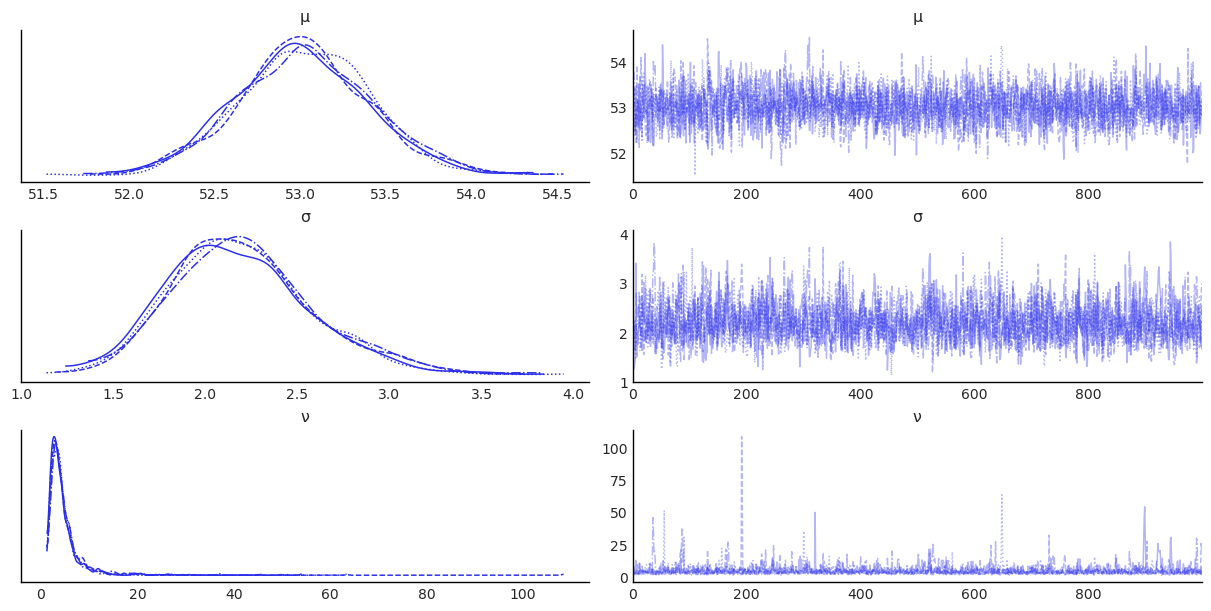

In [23]:
az.plot_trace(idata_t)
plt.savefig('B11197_02_14.png')

In [24]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.023,0.387,52.223,53.694,0.008,0.006,2393.0,2345.0,1.0
σ,2.202,0.389,1.510,2.959,0.009,0.007,1919.0,2022.0,1.0
ν,4.668,4.214,1.315,9.547,0.099,0.070,2152.0,1597.0,1.0


Sampling: [y]


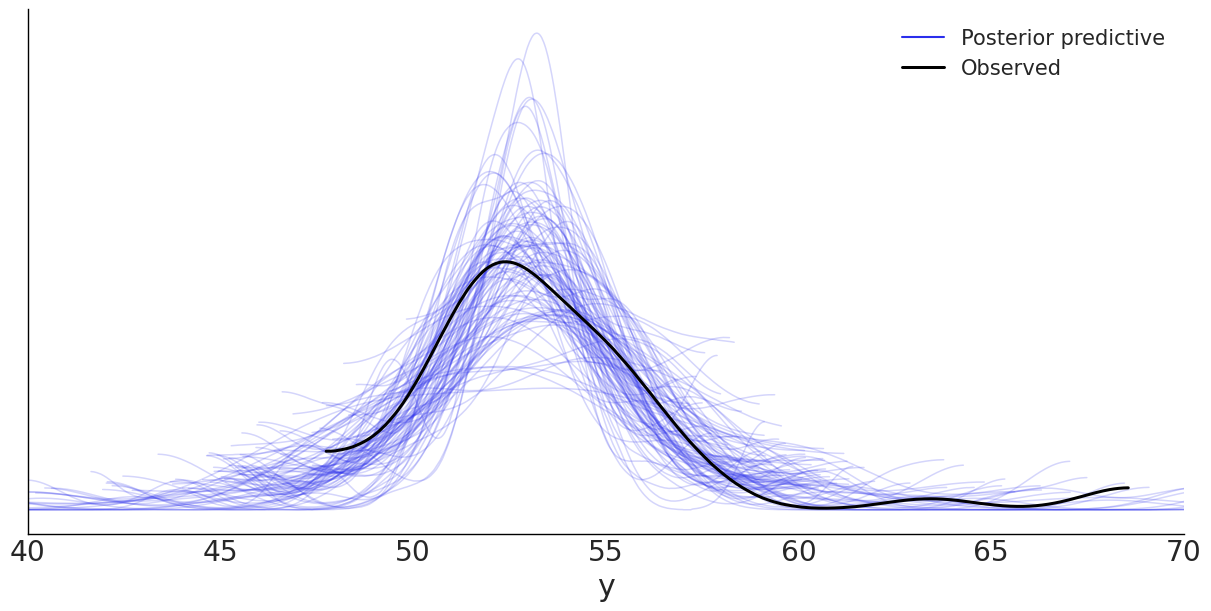

In [25]:
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=123, extend_inferencedata=True)
az.plot_ppc(idata_t, figsize=(12, 6), mean=False, num_pp_samples=100)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png')

# Tips example

In [27]:
tips = pd.read_csv('../../code_3_11/data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


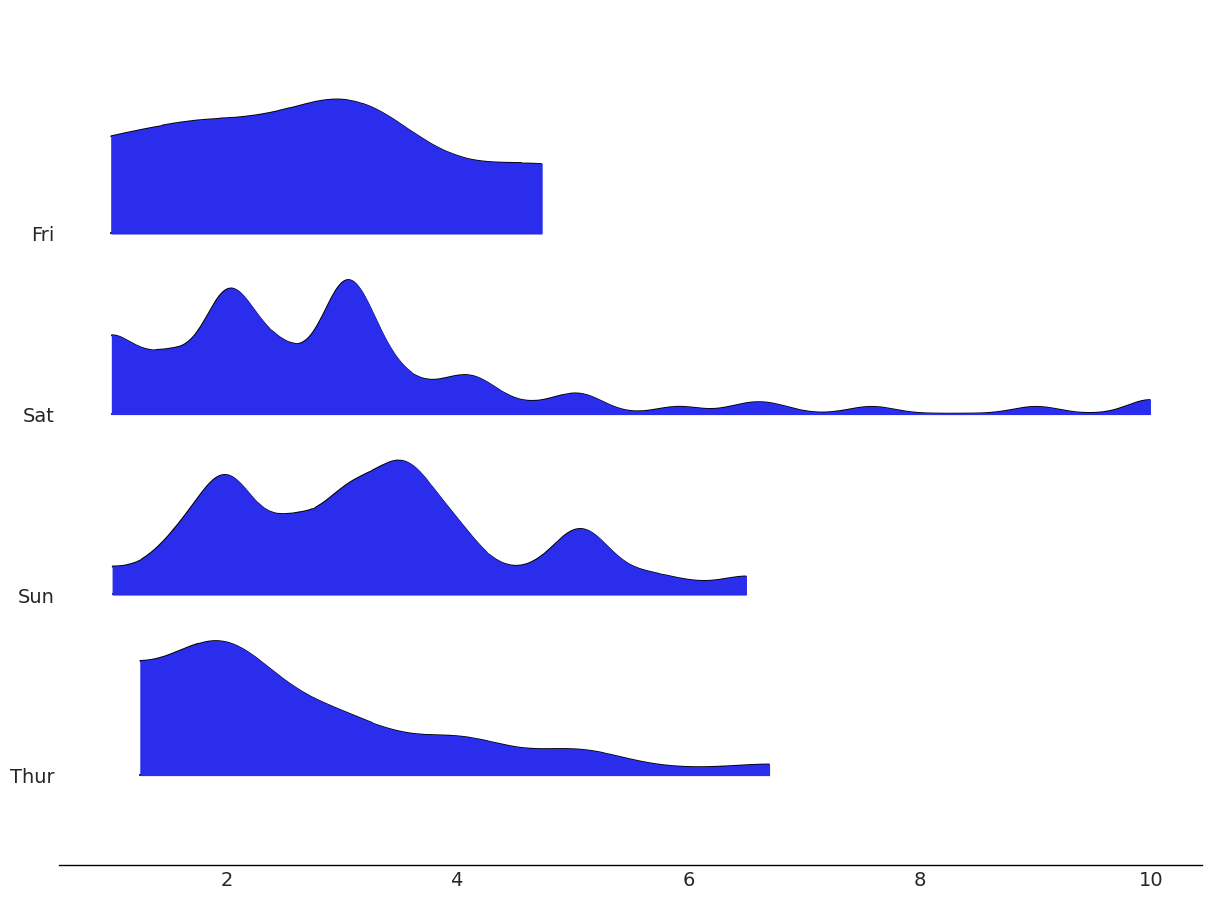

In [28]:
az.plot_forest(tips.pivot(columns='day', values='tip').to_dict('list'),
               kind='ridgeplot',
               hdi_prob=1);
plt.savefig('B11197_02_16.png')

In [29]:
categories = np.array(['Thur', 'Fri', 'Sat', 'Sun'])

tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=categories).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [y]


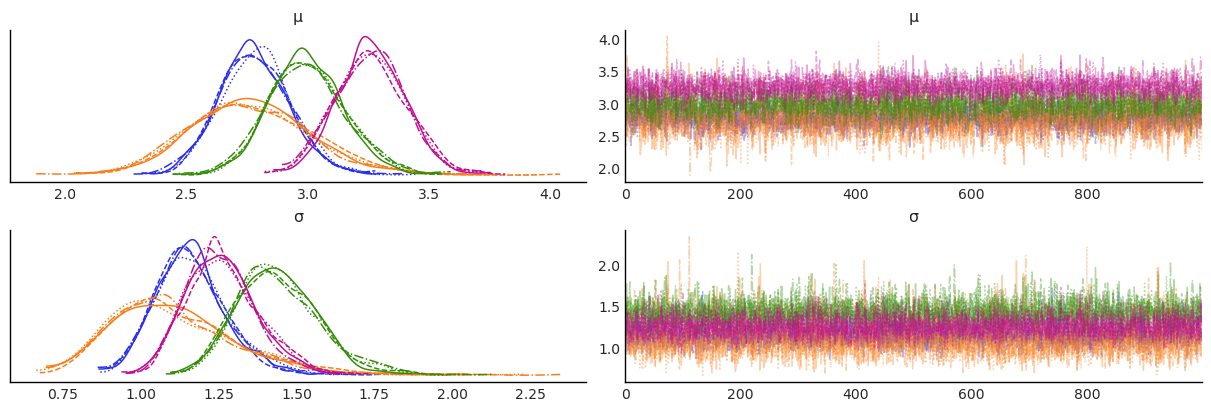

In [30]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal('μ', sigma=5, dims="days")
    σ = pm.HalfNormal('σ', sigma=1, dims="days")

    y = pm.Gamma('y', mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))
az.plot_trace(idata_cg)
plt.savefig('B11197_02_17.png')

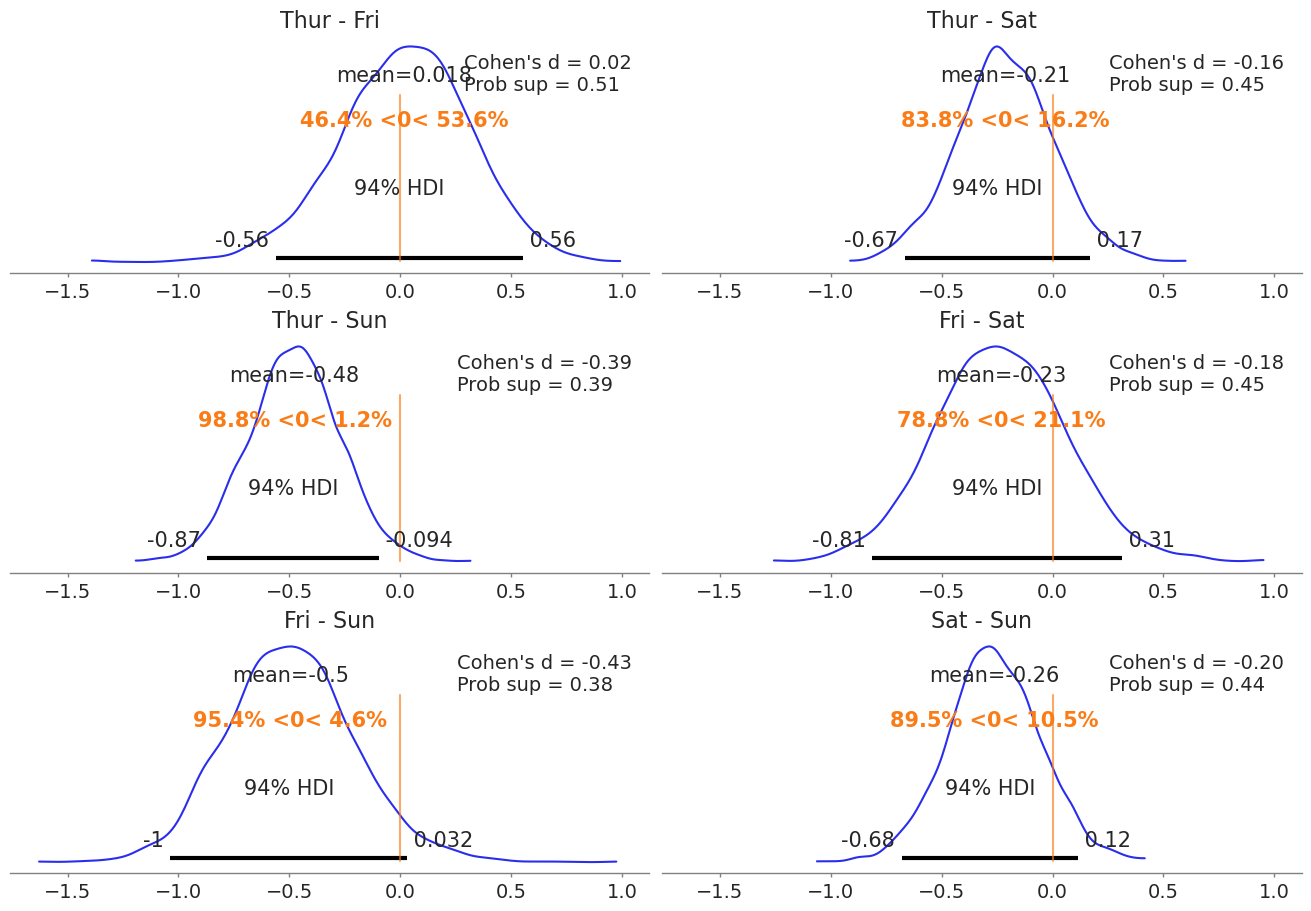

In [31]:
cg_posterior = az.extract(idata_cg)

dist = stats.norm()

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior['μ'].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior['σ'].sel(days=i)**2 + 
                        cg_posterior['σ'].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)
plt.savefig('B11197_02_18.png')

# Hierarchical Models

 <img src="B11197_02_19.png" width="500">

In [32]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [33]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


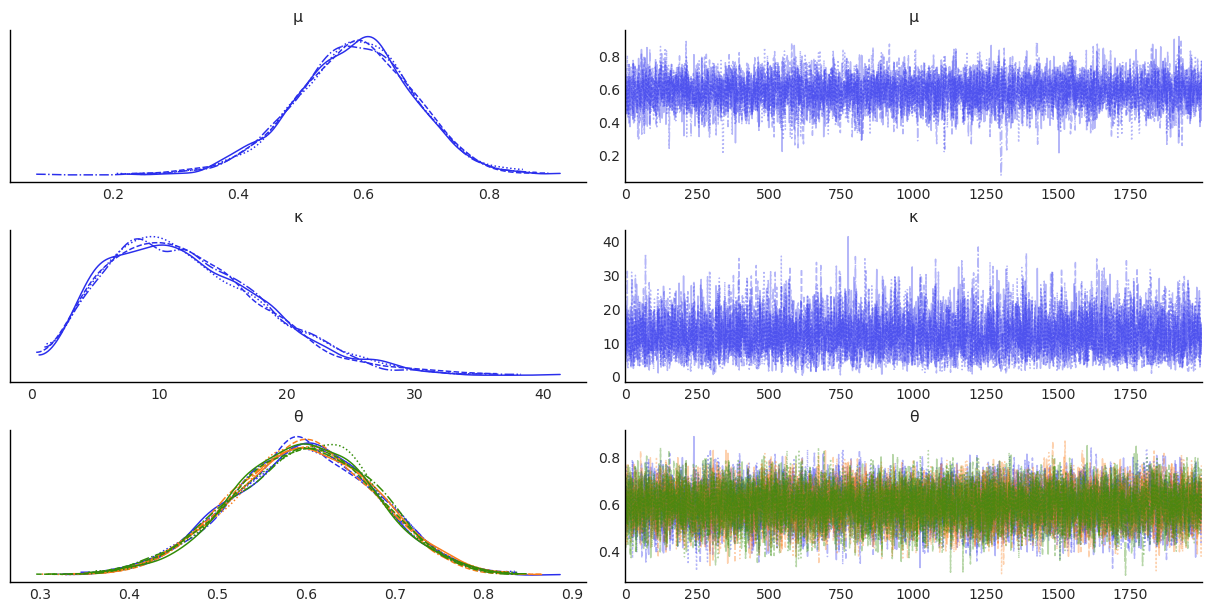

In [34]:
az.plot_trace(idata_h)
plt.savefig('B11197_02_20.png')

In [35]:
az.summary(idata_h)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.584,0.096,0.395,0.757,0.001,0.001,5949.0,4855.0,1.0
κ,12.137,6.147,1.808,23.161,0.075,0.053,5888.0,4517.0,1.0
θ[0],0.597,0.081,0.446,0.746,0.001,0.001,6884.0,6312.0,1.0
θ[1],0.597,0.079,0.451,0.747,0.001,0.001,6357.0,5423.0,1.0
θ[2],0.597,0.080,0.445,0.743,0.001,0.001,7210.0,5026.0,1.0


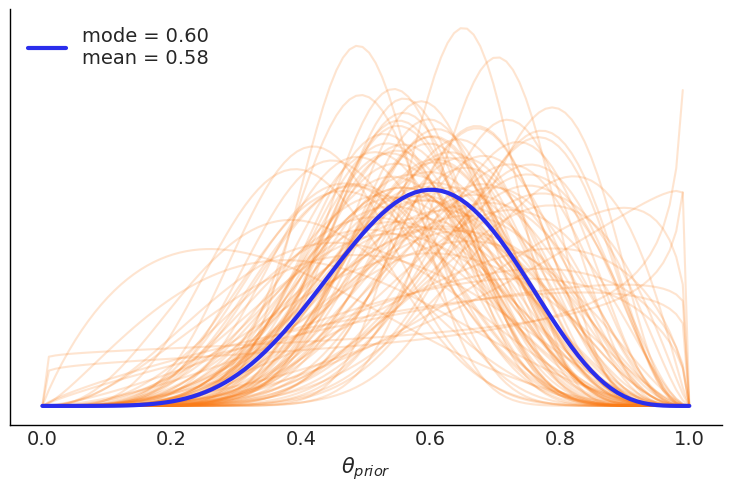

In [36]:
x = np.linspace(0, 1, 100)
posterior_h = az.extract(idata_h)

for i in np.random.randint(0, posterior_h.sample.size, size=100):
    u = posterior_h['μ'][i]
    k = posterior_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = posterior_h['μ'].mean().item()
k_mean = posterior_h['κ'].mean().item()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.savefig('B11197_02_21.png')

In [38]:
cs_data = pd.read_csv('../../code_3_11/data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [39]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [40]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


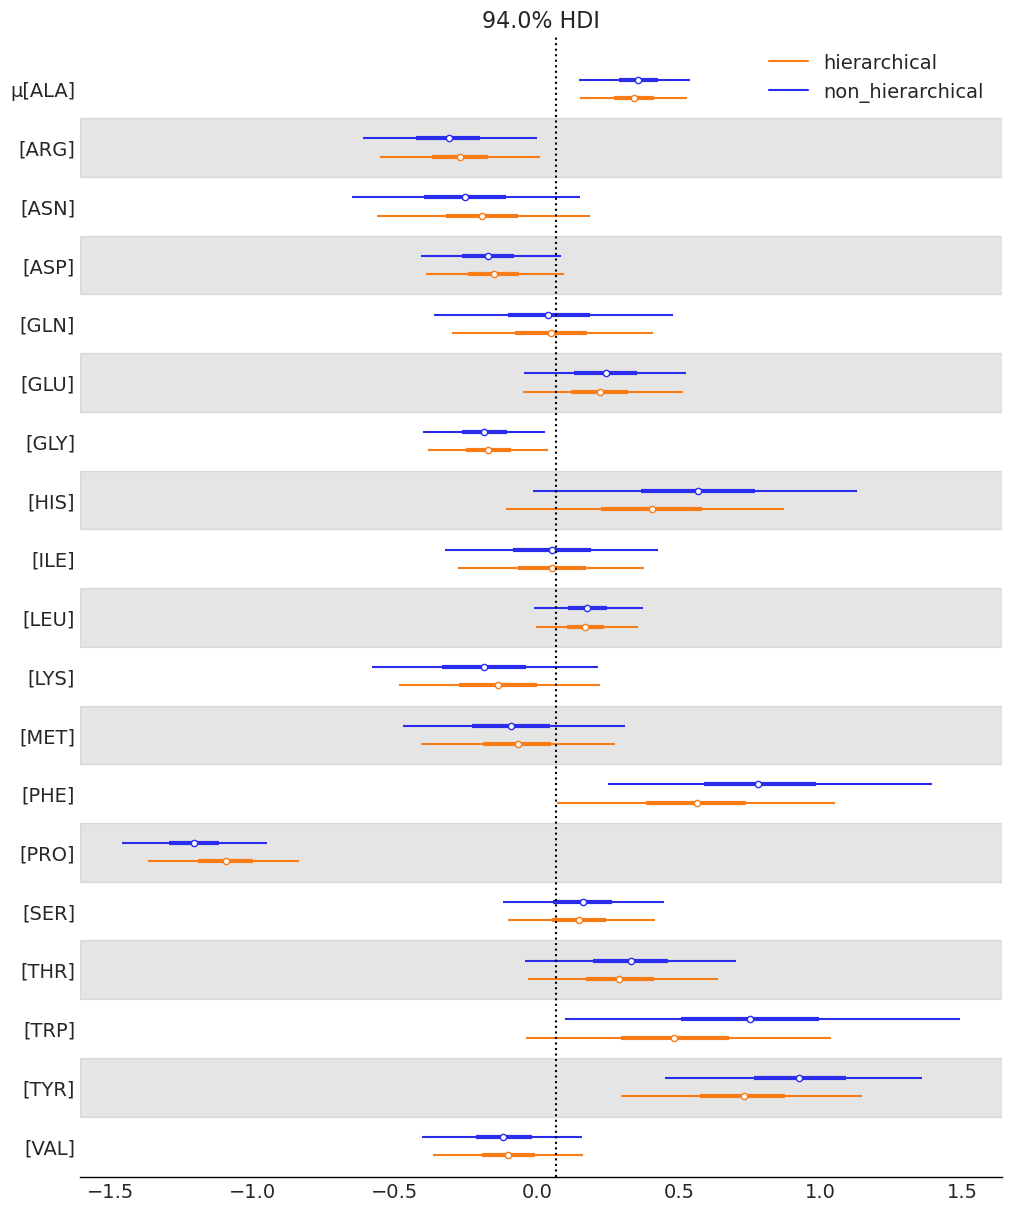

In [41]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")
plt.savefig('B11197_02_22.png')